In [2]:
import numpy as np
import json
import os
import random
import matplotlib.pyplot as plt

## Loading data to use as reference (annotazioni fatte a mano da Andrea)

In [3]:
annotations_qa_root = '/media/data7/DATASET/shapenerf_objanerf_text/spatial_gpt4point_qa/texts'
with open(os.path.join(annotations_qa_root, 'spatial_gpt4point_qa_no_vec.json'), 'r') as f:
    annotations_qa = json.load(f)
print(len(annotations_qa))
print(annotations_qa[0])  

annotations_cap_root = '/media/data7/DATASET/shapenerf_objanerf_text/spatial_gpt4point_cap/texts'
with open(os.path.join(annotations_cap_root, 'spatial_gpt4point_cap.json'), 'r') as f:
    annotations_cap = json.load(f)
print(len(annotations_cap))
print(annotations_cap[0])

data_root = '/media/data7/DATASET/objanerf_text_evaluation_data/imgs_from_objaverse/gpt4point_test'

190
{'object_id': '44795759d6144f61990796c02088665f', 'conversations': [{'from': 'human', 'value': 'What is the rabbit wearing around its neck?\nA: A red necklace\nB: A red tie\nC: A red scarf'}, {'from': 'gpt', 'value': 'C: A red scarf'}]}
100
{'object_id': '1915ece903a5406d8b59b3af3954b943', 'conversations': [{'from': 'human', 'value': '<point>\nProvide a very detailed description of the object knowing that its caption is: "A low-polygon, golden trophy with a small handle base.". Focus on the relative positions of the parts of the object. Include as many details as possible. Do not hallucinate. Focus only on the content of the images. Focus only on the foreground.'}, {'from': 'gpt', 'value': "The trophy is a three-dimensional object with a smooth, golden surface. It has a cylindrical body with a slightly flared top and a very thin circular base. The trophy has two handles: one on each side. The trophy's design is simplistic, with no visible textures or patterns, giving it a uniform a

In [4]:
object_ids = [annotation['object_id'] for annotation in annotations_qa]
object_ids = list(set(object_ids))
print(len(object_ids))

random_id = random.choice(object_ids)
print(random_id)

98
b3e002f575ad4fd59f77537419963a7b


b3e002f575ad4fd59f77537419963a7b
Q 1: What is on top of the circular body of the alarm clock?
A: Two bells
B: One bell
C: Two buttons
====  A: Two bells  ==== 


Q 2: What time do the alarm hands indicate?
A: Ten past ten
B: Eleven past ten
C: Eleven past five
====  A: Ten past ten  ==== 


Q 3: Where is the alarm clock placed?
A: On a square white base
B: On a circular white base
C: Floating in air
====  B: On a circular white base  ==== 


Question: <point>
Provide a very detailed description of the object knowing that its caption is: A yellow alarm clock designed with a bell is placed on a white circular stand.. Focus on the relative positions of the parts of the object. Include as many details as possible. Do not hallucinate. Focus only on the content of the images. Focus only on the foreground.
GT:  This is the 3D model of a yellow alarm clock. It has a yellow body with a white circular dial and black hands. On top of the circula body of the clock, there are two identical yellow b

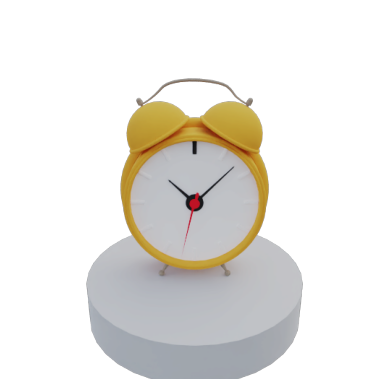

In [5]:
qa = [annotation for annotation in annotations_qa if annotation['object_id'] == random_id]
cap = [annotation for annotation in annotations_cap if annotation['object_id'] == random_id]
#print('QA annotations:', qa[0]['conversations'][0]['value'])
print(random_id)
for i, q in enumerate(qa):
    print(f'Q {i+1}: {q["conversations"][0]["value"]}')
    print('==== ', q['conversations'][1]['value'], ' ==== ')
    print('\n')

print('Question:', cap[0]['conversations'][0]['value'])
print('GT: ', cap[0]['conversations'][1]['value'])
image_path = os.path.join(data_root, random_id, '018.png')
plt.imshow(plt.imread(image_path))
plt.axis('off')
plt.show()

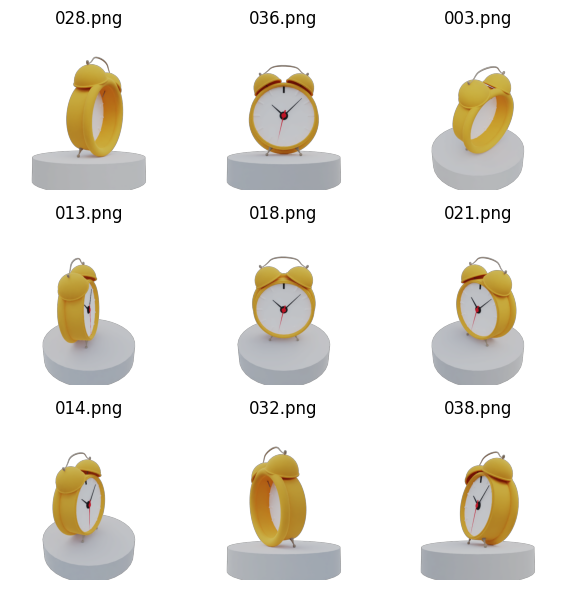

In [6]:
# visualize a grid with all the images of the object
def visualize_object_images(object_id, data_root, num_images=9):
    object_path = os.path.join(data_root, object_id)
    image_files = [f for f in os.listdir(object_path) if f.endswith('.png')]
    random.shuffle(image_files)
    image_files = image_files[:num_images]

    fig, axs = plt.subplots(3, 3, figsize=(6, 6))
    axs = axs.flatten()

    for ax, img_file in zip(axs, image_files):
        img_path = os.path.join(object_path, img_file)
        ax.imshow(plt.imread(img_path))
        ax.axis('off')
        ax.set_title(img_file)

    plt.tight_layout()
    plt.show()

visualize_object_images(random_id, data_root, num_images=9)

# Run VLM on input images

In [7]:
# pip install accelerate
from transformers import AutoProcessor, Gemma3ForConditionalGeneration, BitsAndBytesConfig
from transformers import pipeline
import torch

from PIL import Image

/home/mgaliazzo/.pyenv/versions/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
os.system('export CUDA_HOME=/usr/local/cuda-12.4')
os.system('export PATH=$CUDA_HOME/bin:$PATH')
os.system('export LD_LIBRARY_PATH=$CUDA_HOME/lib64:$LD_LIBRARY_PATH')

0

In [9]:
model_id = "google/gemma-3-12b-it"

# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16,
#     bnb_4bit_use_double_quant=True,
# )

bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

device = 'cuda:2'
model = Gemma3ForConditionalGeneration.from_pretrained(
    # model_id, low_cpu_mem_usage=True, quantization_config=bnb_config, device_map=device
    model_id, low_cpu_mem_usage=True, device_map="auto"
).eval()

processor = AutoProcessor.from_pretrained(model_id)


/home/mgaliazzo/.pyenv/versions/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Loading checkpoint shards: 100%|██████████| 5/5 [00:11<00:00,  2.29s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [10]:
image_names = ['000.png', '010.png', '015.png', '020.png']
data_root = "media7link/gpt4point_test/"
random_id = "ba341c4ce89647ea9f6996ec58e3eacf"

images_paths = [os.path.join(data_root, random_id, img_name) for img_name in image_names]
images = [Image.open(p) for p in images_paths]

question = """
You are an expert image analyst. Your task is to provide a single, comprehensive, and detailed paragraph describing the scene presented in the following series of images.

Focus on creating a rich description that would be useful for someone who cannot see the images. Pay close attention to:

1.  **Main Subject:** Clearly identify the primary object or character.
2.  **Key Attributes:** Describe its color, shape, size, texture, material, and any specific markings, text, or logos.
3.  **Focus on the foreground:** Describe the main object in the scene, not its surroundings.
4.  **Spatial Relationships:** Explain how different elements in the scene are positioned relative to each other (e.g., "the object is on top of the table," "to the left of the building," "partially obscured by a tree").
5.  **State or Action:** Note if the subject is in a particular state (e.g., broken, shiny, old) or performing an action.

**IMPORTANT:** Do NOT create a question, a list, or a QnA. Your entire output should be a single, well-written descriptive paragraph.

Now, based on the images provided, generate your detailed description.
"""

messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are a helpful assistant."}]
    },
    {
        "role": "user",
        "content": [
            *[{"type": "image", "image": img} for img in images],
            {"type": "text", "text": question}
        ]
    }
]

inputs = processor.apply_chat_template(
    messages, add_generation_prompt=True, tokenize=True,
    return_dict=True, return_tensors="pt"
).to(model.device, dtype=torch.bfloat16)

input_len = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=100, do_sample=False)

print("-"*70)
print(generation[0])

print("\n--- Full Decoded Output (including prompt and special tokens) ---")
# Use skip_special_tokens=False to see EVERYTHING
full_decoded = processor.decode(generation[0], skip_special_tokens=False)
print(full_decoded)
print("-"*40)

# **Overall Impression:** The image is a close-up shot of a vibrant garden scene, 
# focusing on a cluster of pink cosmos flowers and a busy bumblebee. 
# It has a slightly soft, natural feel, likely captured in daylight.

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


/home/mgaliazzo/.pyenv/versions/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/mgaliazzo/.pyenv/versions/venv/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:194: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
skipping cudagraphs due to skipping cudagraphs due to multiple devices: device(type='cuda', index=0), device(type='cuda', index=2), device(type='cuda', index=1)


----------------------------------------------------------------------
tensor([    2,   105,  2364,  ..., 48490,   506, 12625], device='cuda:0')

--- Full Decoded Output (including prompt and special tokens) ---
<bos><start_of_turn>user
You are a helpful assistant.



<start_of_image><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_token><image_soft_t

In [11]:
decoded = processor.decode(generation[0], skip_special_tokens=True)
print(decoded)

user
You are a helpful assistant.

















You are an expert image analyst. Your task is to provide a single, comprehensive, and detailed paragraph describing the scene presented in the following series of images.

Focus on creating a rich description that would be useful for someone who cannot see the images. Pay close attention to:

1.  **Main Subject:** Clearly identify the primary object or character.
2.  **Key Attributes:** Describe its color, shape, size, texture, material, and any specific markings, text, or logos.
3.  **Focus on the foreground:** Describe the main object in the scene, not its surroundings.
4.  **Spatial Relationships:** Explain how different elements in the scene are positioned relative to each other (e.g., "the object is on top of the table," "to the left of the building," "partially obscured by a tree").
5.  **State or Action:** Note if the subject is in a particular state (e.g., broken, shiny, old) or performing an action.

**IMPORTANT:** Do NOT crea

In [12]:
model_response = decoded.split('\nmodel\n', 1)[1]
print(model_response)

The images depict a miniature diorama scene featuring two black tractors, each pulling a trailer, positioned on a circular, gray concrete surface. The first tractor, situated on the left, is connected to a trailer filled with what appears to be wood chips or shavings, and has a red mechanical arm extending from its side. The second tractor, on the right, is pulling a trailer also loaded with wood chips. A pile of roughly cut logs is arranged to the right of the tractors, partially overlapping the concrete
